# Usage Of Real Models With Dataset
You have done a great job studying the dataset library and now we have come to the final part of our tutorial.

Here, in this notebook, there is a great pull of info on how to:
* use real models
* create configuration dict with parameters to real models
* draw a distribution of weights.

Using ResNet as an example.

In order not to be bored, let's play around the comparison of two different models.

__First network__ is ResNet34 with simple blocks that looks like this:

<img src='./pictures/simple_block.png'>

Features of this network are:
* use only 3x3 convolution
* 34 layers
* a small number of parameters due to the use of only small convolutions.

__Second model__ - Resnet50 with bottlenecks blocks, which looks like this:

<img src='./pictures/bottle_block.png'>

Features of this network are:
* Two 1 × 1 convolutions inside the block to reduce the dimension.
* 50 layers.
* even fewer parameters due to decreasing dimensions by 1x1 convolutions.

Despite the different number of layers, the number of blocks in these networks is the same.

We will compare them by the set of chosen parameters:
* Speed
* Quality
* Number of parameters.

If you want to know about ResNet more, read: 
* [paper](https://arxiv.org/abs/1512.03385)
* [inplementation](https://github.com/analysiscenter/dataset/blob/master/dataset/models/tf/resnet.py)

In [1]:
import sys
import time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')

import utils
from dataset import B, V, F, Pipeline

from noisedbatch import NoisedBatch
from dataset.dataset.opensets import CIFAR10
from dataset.dataset.models.tf import ResNet34, ResNet50

For the educational purpose in this example use the [CIFAR10](https://analysiscenter.github.io/dataset/api/dataset.opensets.html?highlight=cifar#dataset.opensets.CIFAR10) dataset because it is small as MNSIT but consists of real pictures, therefore more difficult.

In [2]:
dset = CIFAR10(batch_class=NoisedBatch)

Extracting...
Extracted


Real architectures also need to be configured, as are the conventional models that we previously considered

In [3]:
placeholders_config = {
                       'images': {'shape': (128, 128, 3)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

In the __config__, we define all the parameters for our model. Such as __num_blocks__, or __filters__, also you can use ready-made implementations, and in this case, you do not have to manually set the parameters. You can read in documentation about ResNet [params](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html). About ready-made implementation, for example [ResNet18](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html#dataset.models.tf.resnet.ResNet18).

About other models, you have a variety of available [docs](https://analysiscenter.github.io/dataset/api/dataset.models.html).

In [4]:
ResNet34_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
                 'output': dict(ops=['proba', 'labels'])}

ResNet50_config = {**ResNet34_config}

As always - don't forget about feed dict

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

The resize method we took from the ImagesBatch class, which is familiar to us from the [last tutorial](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/II.CNN.ipynb) and the noise creation can be seen in [NoizedBatch](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/III.Models/noisedbatch.py).

In [6]:
image_noise = (Pipeline()
               .resize(shape=(128, 128))
               .normalize_images()
               .create_noise(1.2)
               .add_noise())

Let's look at an example of pictures on which we will train the network.

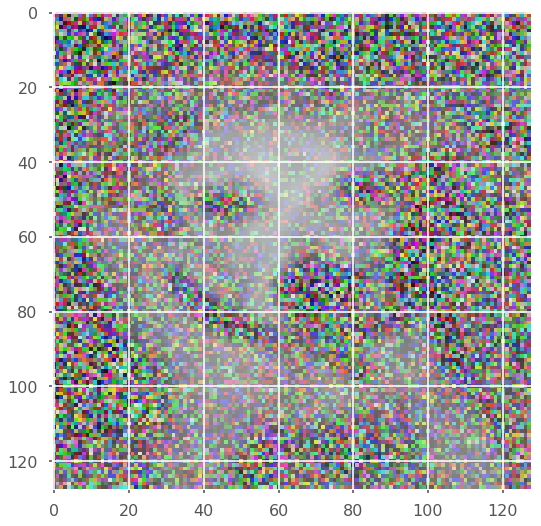

In [22]:
small_ppl = (image_noise<<dset.train).next_batch(1)
plt.imshow(small_ppl.images[0])

Сan you guess what is painted here? No? Interestingly, would the network cope with this task?

It's time to check it!

In [29]:
answers = ['airplane',
          'automobil',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

print("The label was '{}' :)".format(answers[small_ppl.labels[0]]))

The label was 'dog' :)


Based on __ResNet34_confg__, we will create the pipeline for ResNet model

In [9]:
res_tr_ppl = ((image_noise << dset.train)
               .init_model('dynamic',
                          ResNet34,
                          'resnet',
                          config=ResNet34_config)
               .train_model('resnet',
                            feed_dict=placehold_dict))

res_test_ppl = ((image_noise << dset.test)
               .init_variable('resloss', init_on_each_run=list)
               .import_model('resnet', res_tr_ppl)
               .predict_model('resnet',
                            fetches='loss',
                            feed_dict=placehold_dict,
                            save_to=V('resloss'), mode='a'))

Based on __ResNet50_config__, we will create the pipeline to ResNet model with bottleneck blocks

In [10]:
bott_tr_ppl = ((image_noise << dset.train)
                .init_model('dynamic',
                             ResNet50,
                             'bottle',
                             config=ResNet50_config)
                .train_model('bottle',
                             feed_dict=placehold_dict))

bott_test_ppl = ((image_noise << dset.test)
                  .init_variable('bottloss', init_on_each_run=list)
                  .init_variable('bott_predict', init_on_each_run=list)
                  .import_model('bottle', bott_tr_ppl)
                  .predict_model('bottle',
                                 fetches='loss',
                                 feed_dict=placehold_dict,
                                 save_to=V('bottloss'), mode='a'))

Training the model can be achieved with the method already known to us - __next_batch__ and this simultaneously allows us to measure the learning time of each model

In [11]:
resnet_time = 0
bottle_time = 0
for i in tqn(range(300)):
    t = time.time()
    res_tr_ppl.next_batch(50, n_epochs=None, shuffle=True)
    resnet_time += time.time() - t
    res_test_ppl.next_batch(50, n_epochs=None, shuffle=True)

    t = time.time()
    bott_tr_ppl.next_batch(50, n_epochs=None, shuffle=True)
    bottle_time += time.time() - t
    bott_test_ppl.next_batch(50, n_epochs=None, shuffle=True)
print('The training time of the ResNet34 was :\t%f\
       \nThe training time of the ResNet50 was:\t%f'%(resnet_time, bottle_time))

Widget Javascript not detected.  It may not be installed or enabled properly.



The training time of the ResNet34 was :	235.702089       
The training time of the ResNet50 was:	297.158229


It's not difficult to notice that ResNet34 is training faster than ResNet50. But what about the quality?

../../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


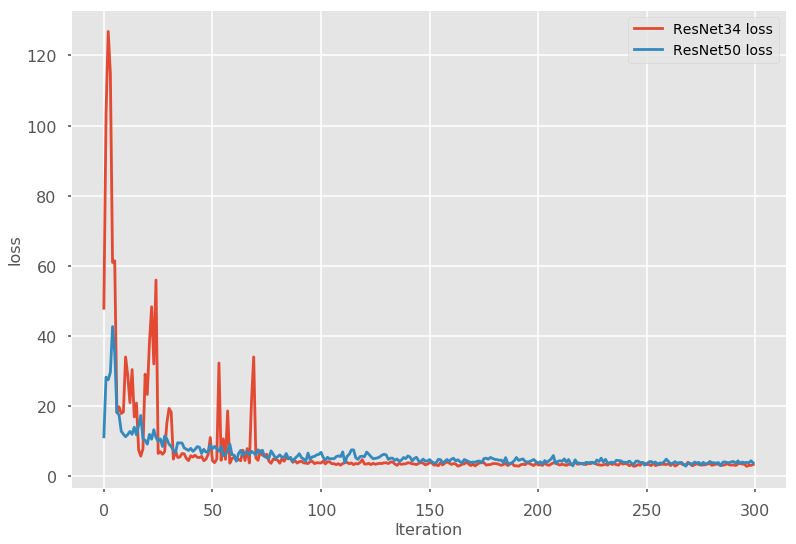

In [12]:
ResNet_loss = res_test_ppl.get_variable('resloss')
Bottle_loss = bott_test_ppl.get_variable('bottloss')
utils.draw(ResNet_loss, 'ResNet34', Bottle_loss, 'ResNet50', window=1)

../../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


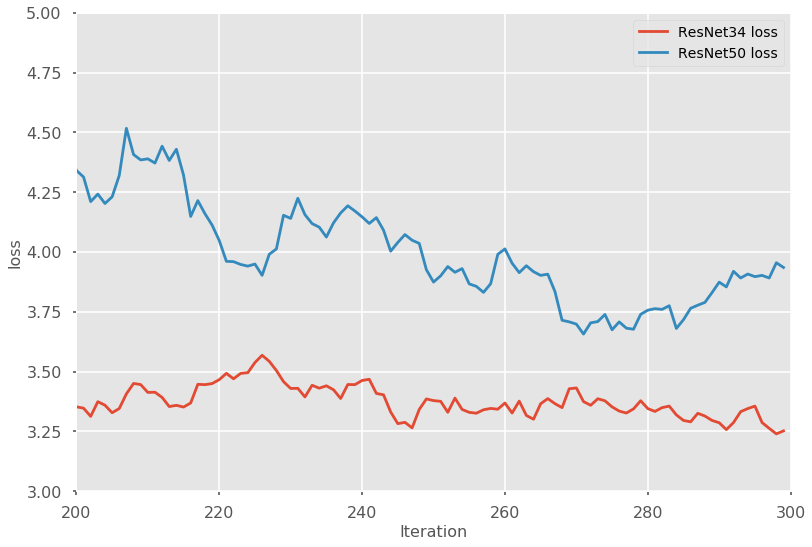

In [24]:
utils.draw(ResNet_loss, 'ResNet34', Bottle_loss, 'ResNet50', window=15, bound=[200, 300, 3, 5])

Looking at the graph makes it clear that ResNet50 has worse quality than ResNet34.

Not only the quality shows how well the network has learned. This can also be understood from how the distribution of weights has changed compared to the initial values. Let's look at the distribution of weights.

But before let's see how the network handled this task by showing the prediction on images.

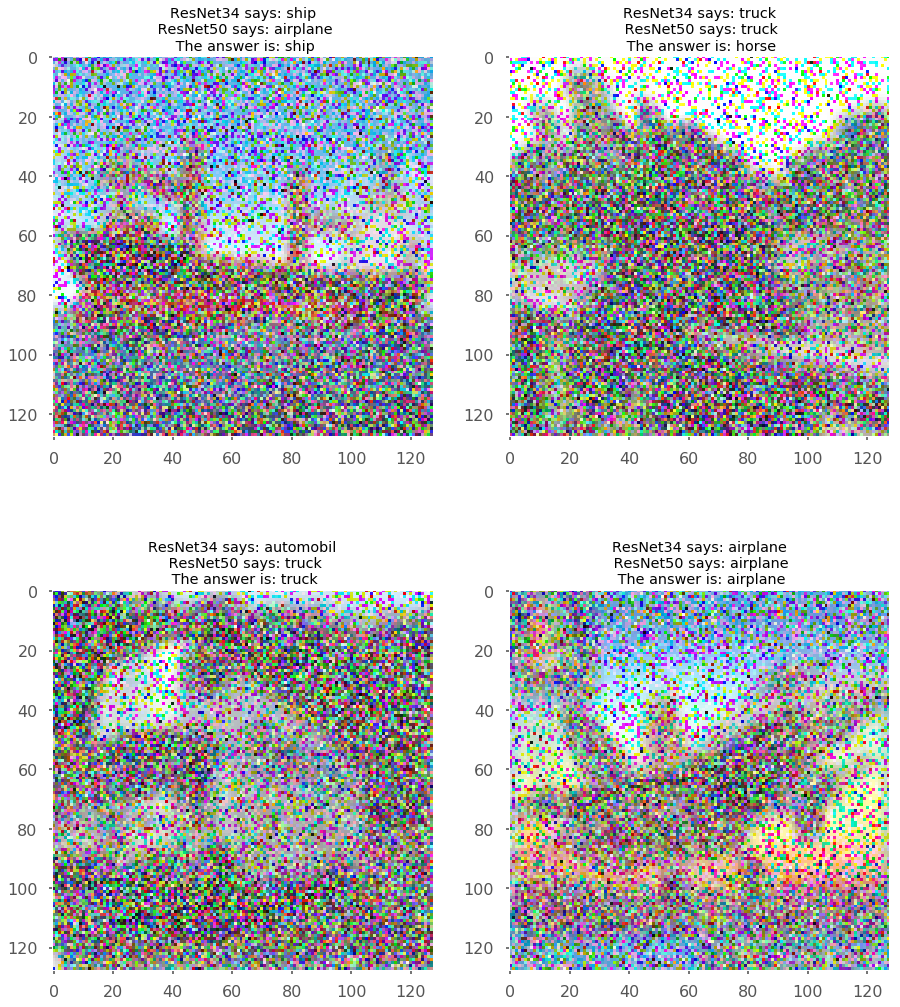

In [14]:
two_model_ppl = ((image_noise << dset.test)
                  .init_variable('bott_label', init_on_each_run=list)
                  .init_variable('res_label', init_on_each_run=list)
                  .init_variable('bott_proba', init_on_each_run=list)
                  .init_variable('res_proba', init_on_each_run=list)
                  .import_model('bottle', bott_tr_ppl)
                  .import_model('resnet', res_tr_ppl)
                  .predict_model('bottle',
                                 fetches=['predicted_labels', 'predicted_proba'],
                                 feed_dict=placehold_dict,
                                 save_to=[V('bott_label'), V('bott_proba')], mode='a')
                  .predict_model('resnet',
                                 fetches=['predicted_labels', 'predicted_proba'],
                                 feed_dict=placehold_dict,
                                 save_to=[V('res_label'), V('res_proba')], mode='a'))

new_batch = two_model_ppl.next_batch(60, n_epochs=None, shuffle=True)
_, ax = plt.subplots(2, 2, figsize=(15, 18))
ax = ax.reshape(-1)
res_ans = two_model_ppl.get_variable('res_label')
bott_ans = two_model_ppl.get_variable('bott_label')
for i in range(4):
    ax[i].grid()
    ax[i].imshow(new_batch.images[i])
    ax[i].set_title('ResNet34 says: {}\n ResNet50 says: {}\n The answer is: {}'\
                    .format(answers[res_ans[0][i]],\
                            answers[bott_ans[0][i]],\
                            answers[new_batch.labels[i]]))

In [28]:
tops = utils.calculate_accuracy(new_batch, two_model_ppl, 'res_proba')
print('ResNet34\nTop 1 accuracy: %.2f \nTop 3 accuracy: %.2f\n'%(tops))
tops = utils.calculate_accuracy(new_batch, two_model_ppl, 'bott_proba')
print('ResNet50\nTop 1 accuracy: %.2f \nTop 3 accuracy: %.2f'%(tops))

ResNet34
Top 1 accuracy: 0.40 
Top 3 accuracy: 0.75

ResNet50
Top 1 accuracy: 0.37 
Top 3 accuracy: 0.62


As you can see in the four images networks make a lot of mistakes, but top 1 and top 5 accuracy looks really good. 

To get weigths from models, first of all, we need to get sessions. Function named [__get_model_by_name__](https://analysiscenter.github.io/dataset/api/dataset.pipeline.html?highlight=get_model_by_name#dataset.Pipeline.get_model_by_name) can help us.

In [16]:
bottle_sess = bott_tr_ppl.get_model_by_name("bottle").session
bottle_names, bottle_weights, bottle_bias = utils.get_weights(bottle_sess)

In [17]:
res_sess = res_tr_ppl.get_model_by_name("resnet").session
res_names, res_weights, res_bias = utils.get_weights(res_sess)

Now we have the weights of the models. It's time to calculate their quantity!

In [18]:
bottle_params = np.array([np.array(i.shape).prod() for i in bottle_weights])
res_params = np.array([np.array(i.shape).prod() for i in res_weights])
print('Total params in ResNet34: %d\nTotal params in ResNet50: %d'%(sum(res_params), sum(bottle_params)))

Total params in ResNet34: 21258240
Total params in ResNet50: 23445504


As you can see, ResNet50 has 2 million parameters more than ResNet34. But the ResNet50 has almost 2 times more layers and only 9% more weights than ResNet34. This shows how much weight the bottleneck block retains.

Below is drawn the distribution of weights of 0, 7th, 10th, 14th blocks from the ResNet50 model. Drawing function you can see in [utils](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/utils.py).

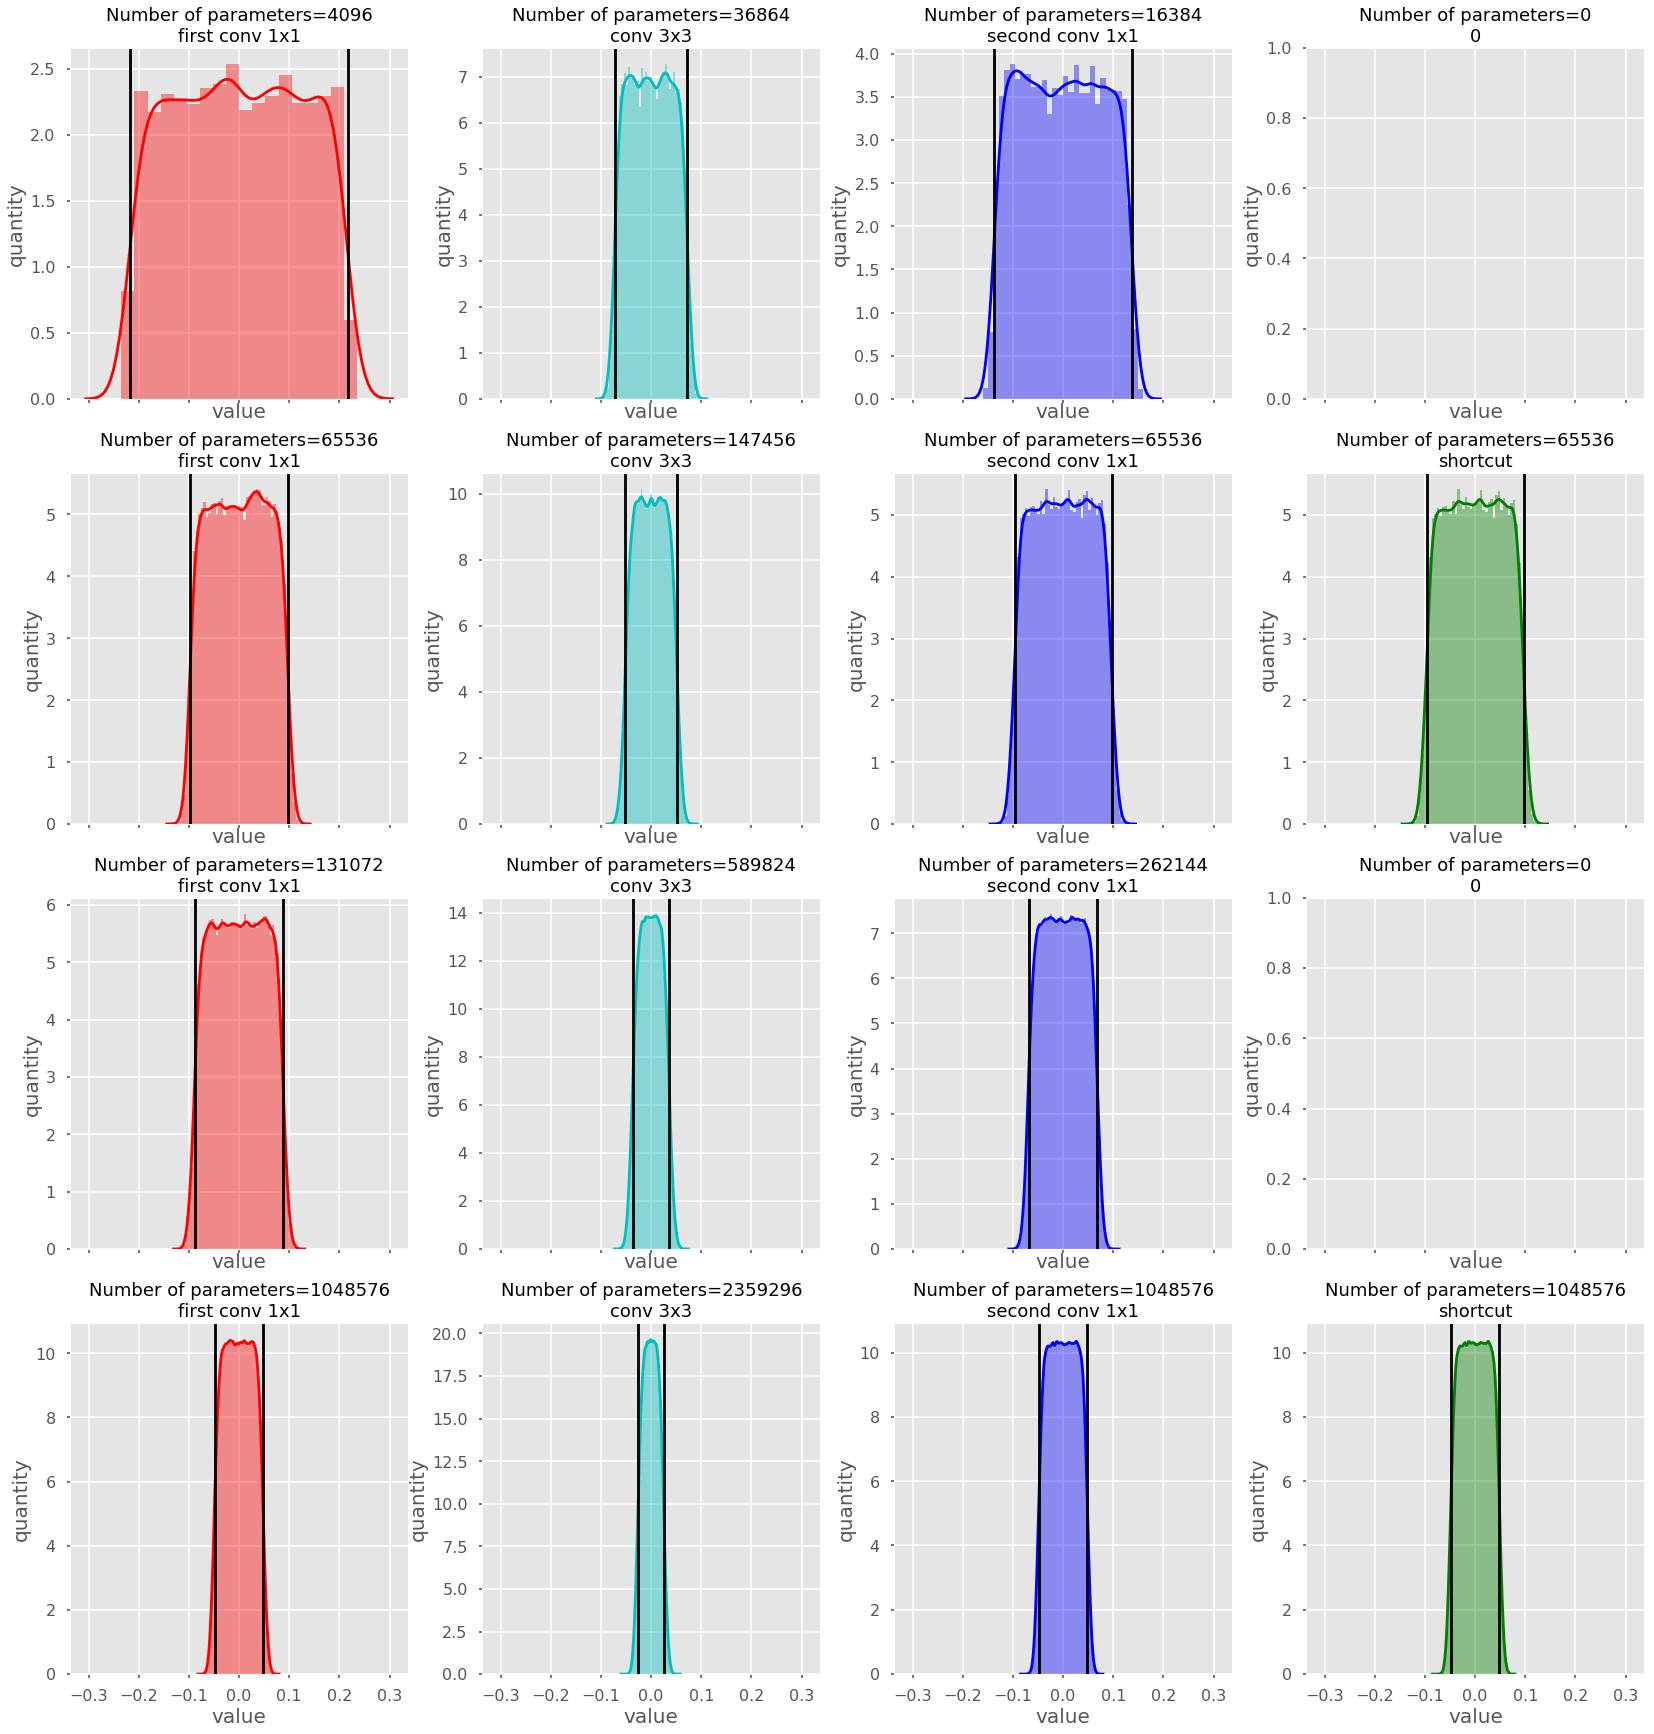

In [19]:
utils.plot_weights(bottle_names, bottle_weights, bottle_params, ['r', 'c', 'b', 'g'], [4, 4], [0, 4, 7, 14])

It's not difficult to notice, that distribution of 1x1 convolutions has a larger variance than in 3x3 convolution. Therefore, they put a stronger influence on output.

 __Black lines show the initial distribution of weights__

______

It's time to draw distribution of 3rd, 4th, 7th, 14th blocks from the ResNet34 model.

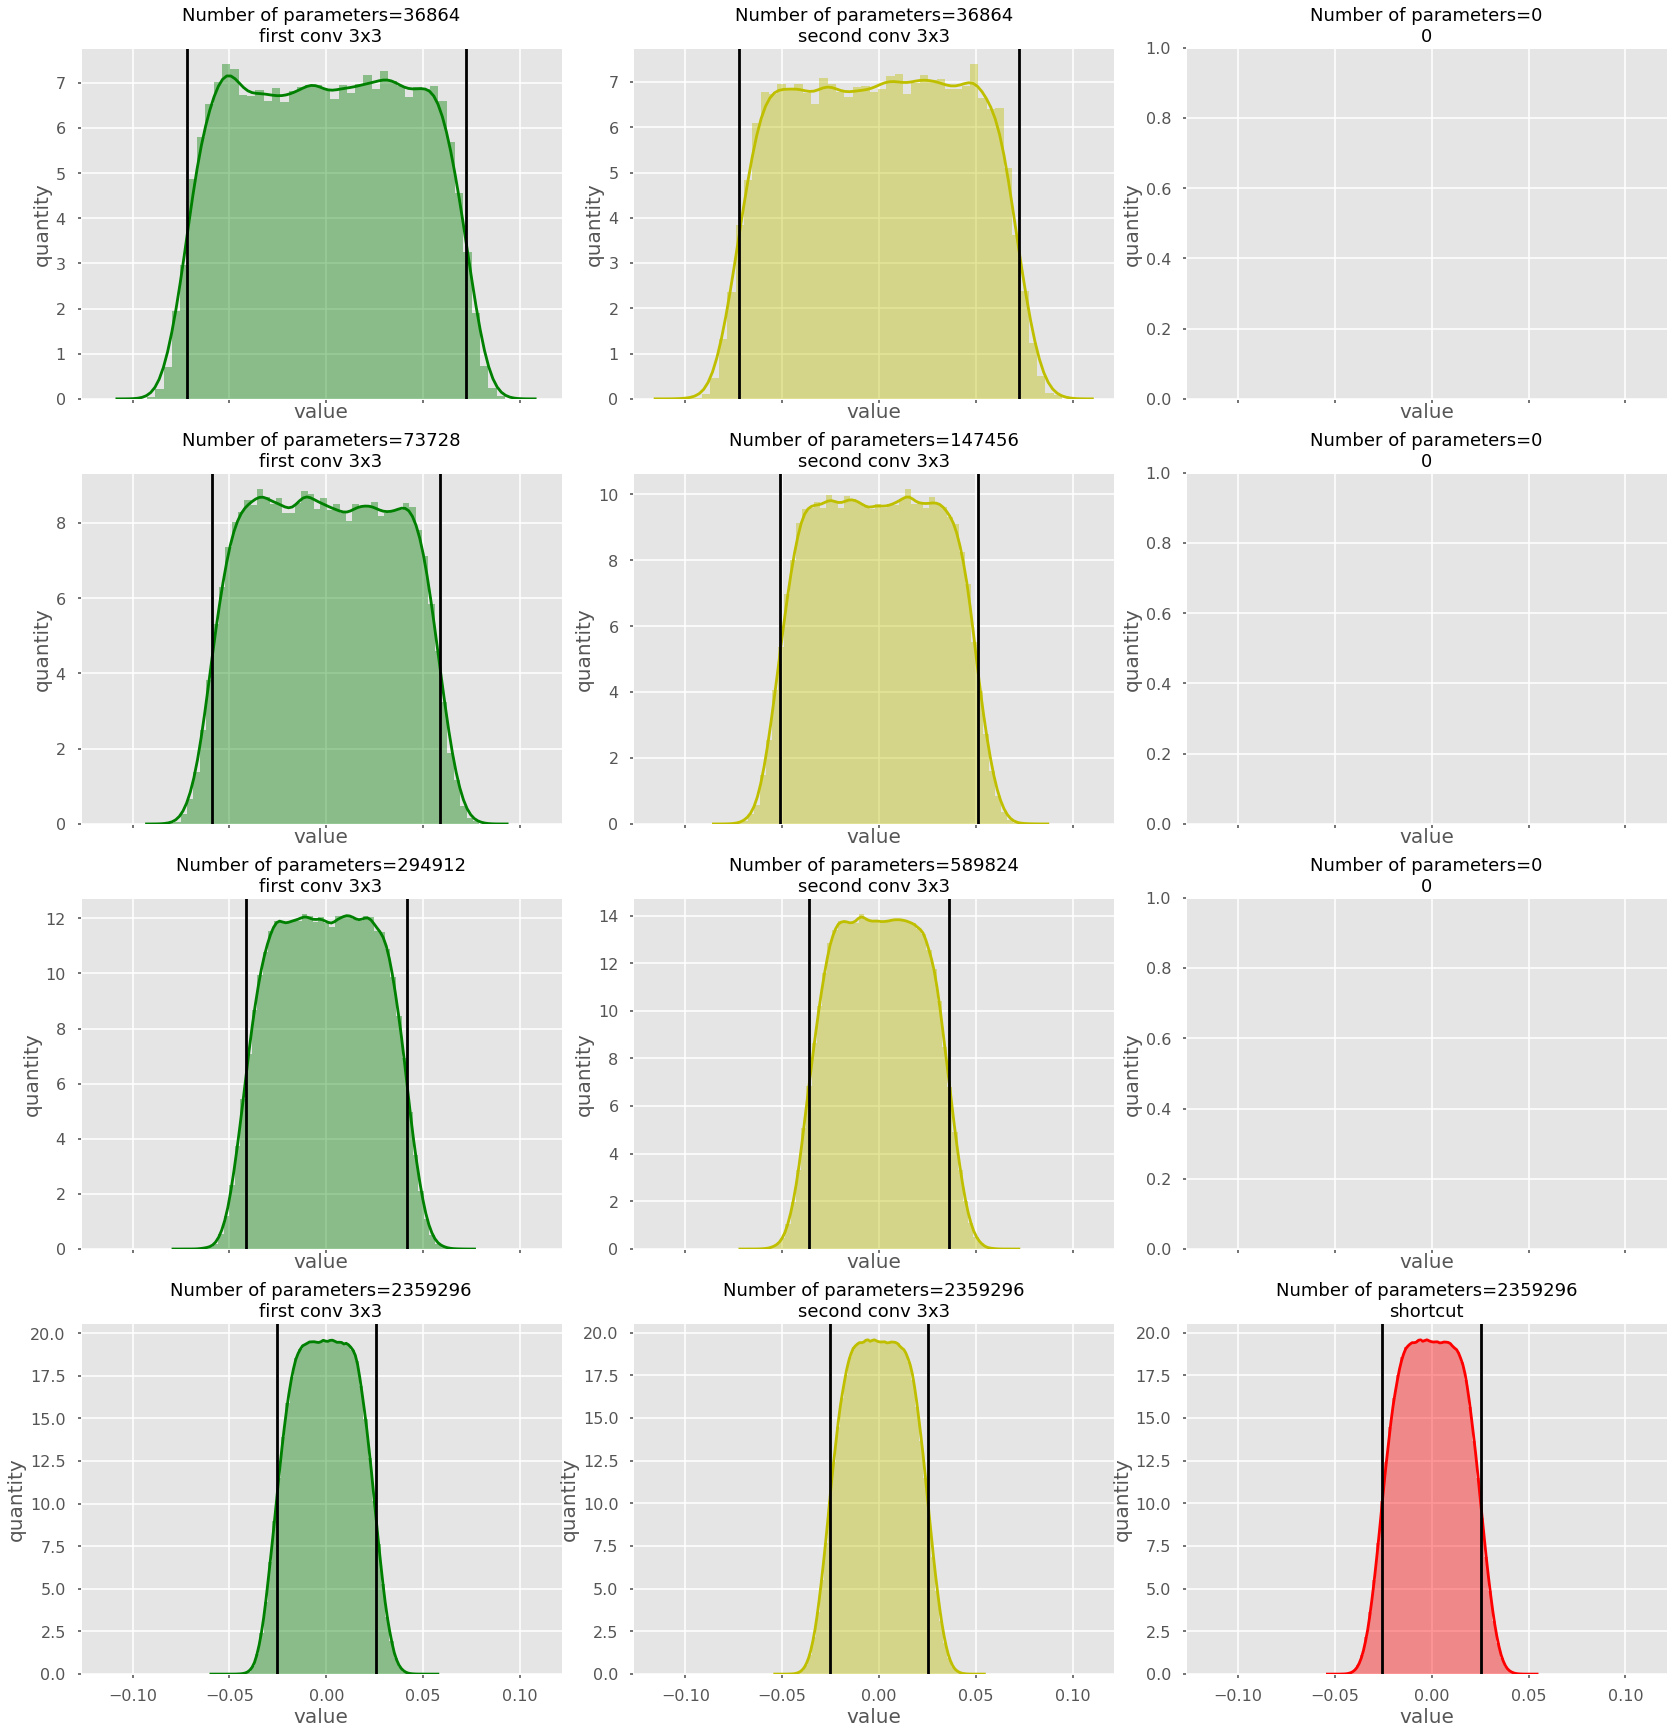

In [20]:
utils.plot_weights(res_names, res_weights, res_params, ['g', 'y', 'r'], [4, 3], [0, 3, 7, 14], bottleneck=False)

It is not difficult to see that the distribution of the 3x3 convolutions is the same.

____

Now, let's compare the distribution of the second layer of ResNet34 architecture and the 3х3 layer of ResNet50 from 3rd, 6th, 9th, 13th blocks. Will they be the same?

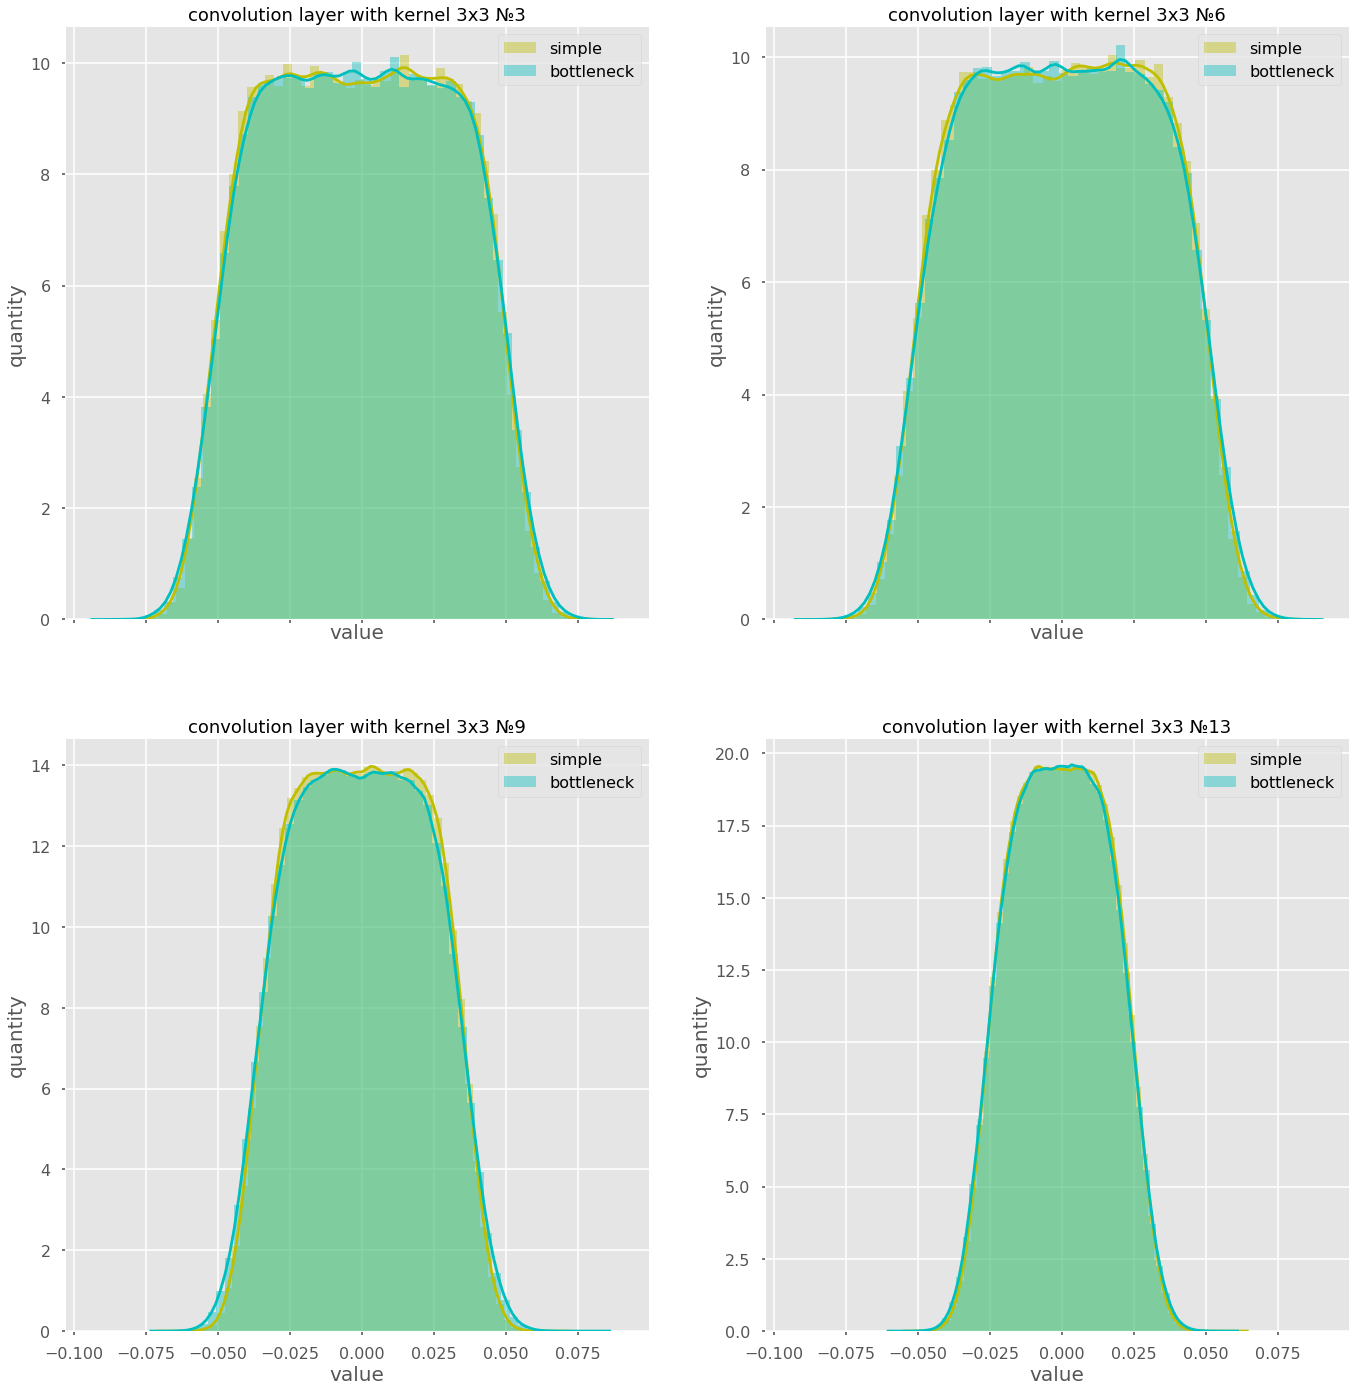

In [21]:
indices = [i for i in range(len(bottle_names)) if 'conv' in bottle_names[i][:8]]
_, ax = plt.subplots(2, 2, sharex='all', figsize=(23, 24))
ax = ax.reshape(-1)
num_plot = 0
num_blocks = [3, 6, 9, 13]
for i,j in zip(np.where(res_names == 'layer-4')[0][num_blocks], np.where(bottle_names == 'layer-4')[0][num_blocks]):
    ax[num_plot].set_title('convolution layer with kernel 3x3 №{}'.format(num_blocks[num_plot]), fontsize=18)
    sns.distplot(res_weights[i].reshape(-1), ax=ax[num_plot], color='y', label='simple')
    sns.distplot(bottle_weights[j].reshape(-1), ax=ax[num_plot], color='c', label='bottleneck')
    ax[num_plot].legend()
    ax[num_plot].set_xlabel('value', fontsize=20)
    ax[num_plot].set_ylabel('quantity', fontsize=20)
    num_plot += 1
    if num_plot == ax.shape[0]:
        break
    

Graphs show, that its distributions are the same. Therefore the other 3x3 convolution layer from ResNet34 replaces the two 1x1 convolutions from ResNet50.

### It's time to conclude:
*  In this task, we have learned how to use real models with the dataset.
*  Now you can configure your own model.
*  Bottleneck block allows you to save a large number of parameters almost without losing quality.
*  Despite the change and noising the data, ResNet50 still proved worse than ResNet34.
*  You can get predictions on real images.

### And what next?
As you can see, using real model almost does not differ from the simple usage of models. We offer you:
* Use ResNet model and train it on MNIST with 3-dimensions.
* Configure it with your own wish.
* And goal the score this time is only 0.99.

Congratulations you finished all training tasks!

In one of our research [ResNet with stochastic depth](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/research/Stochastic_depth/Stochastic_depth.ipynb) is available for you. Take a look at it or observe all [research](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/research).